# Importing Libraries and functions :

In [ ]:
#@title
from __future__ import absolute_import as _
from __future__ import division as _
from __future__ import print_function as _

import getpass as _getpass
import os as _os
import re as _re
import socket as _socket
import sys as _sys
import uuid as _uuid

import pexpect as _pexpect

__all__ = ['mount']


def mount(mountpoint, force_remount=False):
  """Mount your Google Drive at the specified mountpoint path."""

  mountpoint = _os.path.expanduser(mountpoint)
  # If we've already mounted drive at the specified mountpoint, exit now.
  already_mounted = _os.path.isdir(_os.path.join(mountpoint, 'My Drive'))
  if not force_remount and already_mounted:
    print('Drive already mounted at {}; to attempt to forcibly remount, '
          'call drive.mount("{}", force_remount=True).'.format(
              mountpoint, mountpoint))
    return
  home = _os.environ['HOME']
  root_dir = _os.path.realpath(
      _os.path.join(_os.environ['CLOUDSDK_CONFIG'], '../..'))
  inet_family = 'IPV4_ONLY'
  dev = '/dev/fuse'
  path = '/usr/local/bin:/usr/local/sbin:/usr/bin:/usr/sbin:/bin:/sbin:.'
  if len(root_dir) > 1:
    home = _os.path.join(root_dir, home)
    inet_family = 'IPV6_ONLY'
    fum = _os.environ['HOME'].split('mount')[0] + '/mount/alloc/fusermount'
    dev = fum + '/dev/fuse'
    path = path + ':' + fum + '/bin'
  config_dir = _os.path.join(home, '.config', 'Google')
  try:
    _os.makedirs(config_dir)
  except OSError:
    if not _os.path.isdir(config_dir):
      raise ValueError('{} must be a directory if present'.format(config_dir))

  # Launch an intermediate bash inside of which drive is launched, so that
  # after auth is done we can daemonize drive with its stdout/err no longer
  # being captured by pexpect. Otherwise buffers will eventually fill up and
  # drive may hang, because pexpect doesn't have a .startDiscardingOutput()
  # call (https://github.com/pexpect/pexpect/issues/54).
  prompt = u'root@{}-{}: '.format(_socket.gethostname(), _uuid.uuid4().hex)
  d = _pexpect.spawn(
      '/bin/bash',
      args=['--noediting'],
      timeout=120,
      maxread=int(1e6),
      encoding='utf-8',
      env={
          'HOME': home,
          'FUSE_DEV_NAME': dev,
          'PATH': path
      })
  if mount._DEBUG:  # pylint:disable=protected-access
    d.logfile_read = _sys.stdout
  d.sendline('export PS1="{}"'.format(prompt))
  d.expect(prompt)  # The echoed input above.
  d.expect(prompt)  # The new prompt.
  # Robustify to previously-running copies of drive. Don't only [pkill -9]
  # because that leaves enough cruft behind in the mount table that future
  # operations fail with "Transport endpoint is not connected".
  d.sendline('umount -f {mnt} || umount {mnt}; pkill -9 -x drive'.format(
      mnt=mountpoint))
  # Wait for above to be received, using the next prompt.
  d.expect(u'pkill')  # Echoed command.
  d.expect(prompt)
  # Only check the mountpoint after potentially unmounting/pkill'ing above.
  try:
    if _os.path.islink(mountpoint):
      raise ValueError('Mountpoint must not be a symlink')
    if _os.path.isdir(mountpoint) and _os.listdir(mountpoint):
      raise ValueError('Mountpoint must not already contain files')
    if not _os.path.isdir(mountpoint) and _os.path.exists(mountpoint):
      raise ValueError('Mountpoint must either be a directory or not exist')
#    if '/' in mountpoint and not _os.path.exists(_os.path.dirname(mountpoint)):
#     raise ValueError('Mountpoint must be in a directory that exists')
  except:
    d.terminate(force=True)
    raise

  # Watch for success.
  success = u'google.colab.drive MOUNTED'
  success_watcher = (
      '( while `sleep 0.5`; do if [[ -d "{m}" && "$(ls -A {m})" != "" ]]; '
      'then echo "{s}"; break; fi; done ) &').format(
          m=mountpoint, s=success)
  d.sendline(success_watcher)
  d.expect(prompt)  # Eat the match of the input command above being echoed.
  drive_dir = _os.path.join(root_dir, 'opt/google/drive')
  d.sendline(
      ('{d}/drive --features=opendir_timeout_ms:15000,virtual_folders:true '
       '--inet_family=' + inet_family + ' '
       '--preferences=trusted_root_certs_file_path:'
       '{d}/roots.pem,mount_point_path:{mnt} --console_auth').format(
           d=drive_dir, mnt=mountpoint))

  while True:
    case = d.expect([
        success, prompt,
        _re.compile(u'(Go to this URL in a browser: https://.*)\r\n')
    ])
    if case == 0:
      break
    elif case == 1:
      # Prompt appearing here means something went wrong with the drive binary.
      d.terminate(force=True)
      raise ValueError('mount failed')
    elif case == 2:
      # Not already authorized, so do the authorization dance.
      prompt = d.match.group(1) + '\n\nEnter your authorization code:\n'
      d.send(_getpass.getpass(prompt) + '\n')
  d.sendcontrol('z')
  d.expect(u'Stopped')
  d.sendline('bg; disown; exit')
  d.expect(_pexpect.EOF)
  assert not d.isalive()
  assert d.exitstatus == 0
  print('Mounted at {}'.format(mountpoint))


mount._DEBUG = False  # pylint:disable=protected-access

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve ,auc ,confusion_matrix 
from sklearn.decomposition import TruncatedSVD

from scipy.spatial.distance import cosine
from sklearn.preprocessing import StandardScaler
from seaborn import heatmap

from prettytable import PrettyTable

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Changing Directory
import os
os.chdir("/content/drive/My Drive/Colab Notebooks")
!ls

'''
# RAM info
!cat /proc/meminfo

# CPU info
!cat /proc/cpuinfo
'''

'02 Amazon Fine Food Reviews Analysis_TSNE.ipynb'
 3Layered_CNN_MNIST.ipynb
 Amz30kTest
 Amz70kTrain
 Assignemnt_Keras_Mnist.ipynb
 Assignemnt_Keras_Mnist_v2.ipynb
'Assignment_02 Amazon Fine Food Reviews Analysis_TSNE.ipynb'
'Assignment_07_Support Vector Machines.ipynb'
 best_model2L.h5
 best_model3L.h5
 best_model5L.h5
'Copy of 1.Python Assignment.ipynb'
'Copy of Recommendation_system_assignment.ipynb'
 database.sqlite
 __pycache__
 RBF_SVM_GridModels


'\n# RAM info\n!cat /proc/meminfo\n\n# CPU info\n!cat /proc/cpuinfo\n'

In [ ]:
con = sqlite3.connect('database.sqlite') 
not_3_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

def partition(x):
        if x < 3:
                return 0
        else :
                return 1

# Re-Labeling scores 0 for '<3' and 1 for '>3'  
ActualScore = not_3_data["Score"]
PosNeg = ActualScore.map(partition)
not_3_data["Score"] = PosNeg

#checking heads of Dataset
not_3_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data Cleaning :

In [ ]:
# Sorting Data 
sorted_data = not_3_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# De-Duplication of rows in Dataset -- Primary Key ("UserId","Profile Name","Time","Text")
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

# Helpfulness Denominator always greater than Helpfulness Numerator ,removing rows that don't follow the same: 
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print("Dimensions are : ",final.shape)

g=final.groupby('Score',as_index = False)
g.count()

Dimensions are :  (364171, 10)


,Score,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text
0,0,57110,57110,57110,57110,57110,57110,57110,57110,57110
1,1,307061,307061,307061,307061,307061,307061,307061,307061,307061


## Taking latest 50k and 20k reviews from 364k reviews : (No random sampling to be done as time based order of reviews matters)
#### Just for the sake of less computational time.

In [ ]:
fin50kSample = final.tail(n = 50000)
fin20kSample = final.tail(n = 20000)

# Just to check whether the distribution of Score is same or not.
g = fin50kSample.groupby('Score' , as_index = False)
print(g.count()['Id'])
g = fin20kSample.groupby('Score' , as_index = False)
print(g.count()['Id'])

#just to free up some amount of RAM
final=[];sorted_data=[];not_3_data=[];con=[];

0     8637
1    41363
Name: Id, dtype: int64
0     3381
1    16619
Name: Id, dtype: int64


In [ ]:
# Removing HTML Tags, Stopwords, Punctuations and stemming
nltk.download('stopwords')

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
final_string=[];i=0;
for sent in tqdm(fin50kSample['Text'].values):
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
    str1 = b" ".join(filtered_sentence)
    final_string.append(str1);i+=1;
fin50kSample['CleanedText']=final_string
fin50kSample['CleanedText']=fin50kSample['CleanedText'].str.decode("utf-8")

final_string=[];i=0;
for sent in tqdm(fin20kSample['Text'].values):
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
    str1 = b" ".join(filtered_sentence)
    final_string.append(str1);i+=1;
fin20kSample['CleanedText']=final_string
fin20kSample['CleanedText']=fin20kSample['CleanedText'].str.decode("utf-8")


100%|██████████| 20000/20000 [00:14<00:00, 1347.17it/s]


In [ ]:
# Sampling 50k points for train(70%) and test(30%) in brute force implementation of kNN
nrow, ncol = fin50kSample.shape

final_50ktrain = fin50kSample.head(n = round(nrow*0.7))
final_50ktest = fin50kSample.tail(n = nrow-round(nrow*0.7))

print("Dimensions of Train and Test Dataset of 50k samples is ",final_50ktrain.shape,"&",final_50ktest.shape,"resp.")

# Sampling 20k points for train(70%) and test(30%) in kd tree implementation of kNN
nrow, ncol = fin20kSample.shape

final_20ktrain = fin20kSample.head(n = round(nrow*0.7))
final_20ktest = fin20kSample.tail(n = nrow-round(nrow*0.7))


print("Dimensions of Train and Test Dataset of 20k samples is ",final_20ktrain.shape,"&",final_20ktest.shape,"resp.")


Dimensions of Train and Test Dataset of 50k samples is  (35000, 11) & (15000, 11) resp.
Dimensions of Train and Test Dataset of 20k samples is  (14000, 11) & (6000, 11) resp.


In [ ]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

# kNN for BoW encoding:

**using kd-tree algorithm , hyperparameter tuning - ploting k v/s AUROC for Validation dataset and Train dataset **

100%|██████████| 29/29 [5:15:48<00:00, 647.74s/it]


Text(0, 0.5, 'AUROC score')

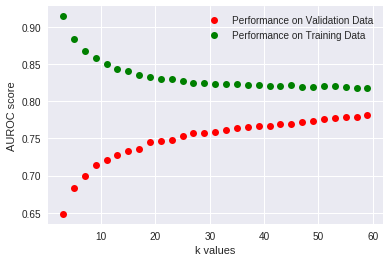

In [ ]:
myList = list(range(3,61,2));

tcvs = TimeSeriesSplit(n_splits = 10, max_train_size = round(final_20ktrain.shape[0]*0.9))
ValMeanScore=[]; TrainMeanScore=[];
count_vect = CountVectorizer(ngram_range=(1,2), min_df = 10, max_features = 500)

for k in tqdm(myList) :
    
    ValScore=[];TrainScore=[];
    knn = KNeighborsClassifier(n_neighbors=k ,algorithm = "kd_tree")
    
    for train ,val in tcvs.split(final_20ktrain) :
        
        Xtrain_bigrams = count_vect.fit_transform(final_20ktrain.iloc[train]['CleanedText'].values)
        scaler = StandardScaler(with_mean = False)
        scaler.fit_transform(Xtrain_bigrams)
        
        Xval_bigrams = count_vect.transform(final_20ktrain.iloc[val]['CleanedText'].values)
        scaler.transform(Xval_bigrams)
                
        Ytrain_labels = final_20ktrain.iloc[train]['Score']
        Yval_labels = final_20ktrain.iloc[val]['Score']
        
        knn.fit(Xtrain_bigrams.toarray(), Ytrain_labels)
        
        predOnVal = knn.predict_proba(Xval_bigrams.toarray())
        predOnTrain = knn.predict_proba(Xtrain_bigrams.toarray())
        
        fpr,tpr,_ = roc_curve(Yval_labels, predOnVal[:,1])
        AUCOnVal = auc(fpr,tpr)
        fpr,tpr,_ = roc_curve(Ytrain_labels, predOnTrain[:,1])
        AUCOnTrain = auc(fpr,tpr)
        
        ValScore.append(AUCOnVal)
        TrainScore.append(AUCOnTrain)
        
    ValMeanScore.append((k,sum(ValScore)/len(ValScore)))
    TrainMeanScore.append((k,sum(TrainScore)/len(TrainScore)))
    
#just to free up some memory space :
Xval_bigrams =[];train=[];val=[];

ValMeanScore = dict(ValMeanScore)
TrainMeanScore = dict(TrainMeanScore)

#Bestk = list(ValMeanScore.keys())[list(ValMeanScore.values()).index(max(ValMeanScore.values()))]

plt.plot(ValMeanScore.keys(), ValMeanScore.values(), "ro", label = "Performance on Validation Data")
plt.plot(TrainMeanScore.keys(), TrainMeanScore.values(),"go", label = "Performance on Training Data")
plt.legend()
plt.xlabel("k values")
plt.ylabel("AUROC score")


**Performance on Test Data with optimal k value , ROC Curves and Confusion Matrix**

*************************************************************************************
Performance on test and train data is 0.7972282132709919 & 0.8327269765945877 resp.
*************************************************************************************


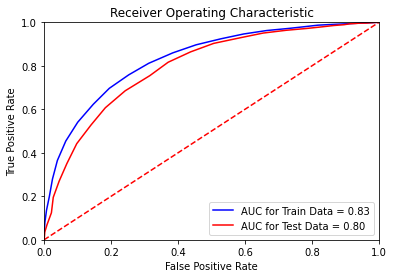

the maximum value of tpr*(1-fpr) 0.5192638078588767 for threshold 0.814
*************************************************************************************

Best threshold from the above ROC curve on Test data is  0.8135593220338984
*************************************************************************************



Text(0.5, 6.0, 'Predicted label')

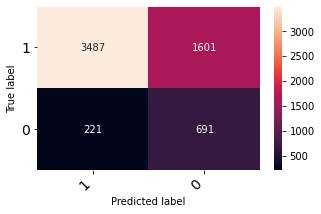

In [ ]:
count_vect = CountVectorizer(ngram_range=(1,2), min_df = 10, max_features = 500)

Xtrain_bigrams = count_vect.fit_transform(final_20ktrain['CleanedText'].values)
scaler = StandardScaler(with_mean = False)
scaler.fit_transform(Xtrain_bigrams)

Xtest_bigrams = count_vect.transform(final_20ktest['CleanedText'].values)
scaler.transform(Xtest_bigrams)

knn = KNeighborsClassifier(n_neighbors = 59 , algorithm = 'kd_tree')

knn.fit(Xtrain_bigrams.toarray(), final_20ktrain['Score'])
predOnTest = knn.predict_proba(Xtest_bigrams.toarray())
predOnTrain = knn.predict_proba(Xtrain_bigrams.toarray())

Trainfpr,Traintpr,Trthrsh = roc_curve(final_20ktrain['Score'], predOnTrain[:,1])
train_auc = auc(Trainfpr,Traintpr)

Testfpr,Testtpr,Tsthrsh = roc_curve(final_20ktest['Score'], predOnTest[:,1])
test_auc = auc(Testfpr,Testtpr)

print("*************************************************************************************")
print("Performance on test and train data is", test_auc,"&",train_auc,"resp.")
print("*************************************************************************************")

Xtrain_bigrams=[];

## Ploting ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(Trainfpr, Traintpr, 'b', label = 'AUC for Train Data = %0.2f' % train_auc)
plt.plot(Testfpr, Testtpr, 'r', label = 'AUC for Test Data = %0.2f' % test_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

best_t = find_best_threshold(Tsthrsh, Testfpr, Testtpr)

print("*************************************************************************************\n")

print("Best threshold from the above ROC curve on Test data is ", best_t)

print("*************************************************************************************\n")

class_names = [1,0]
confMat=confusion_matrix(final_20ktest['Score'], predict_with_best_t(predOnTest[:,1], best_t), labels = class_names)
df_cm = pd.DataFrame(confMat, index=class_names, columns=class_names)
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')


**using Brute Force algorithm , hyperparameter tuning - ploting k v/s AUROC for Validation dataset and Train dataset **

100%|██████████| 29/29 [2:00:40<00:00, 247.92s/it]


Text(0, 0.5, 'AUROC score')

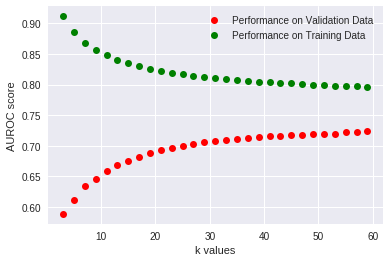

In [ ]:
myList = list(range(3,61,2));

tcvs = TimeSeriesSplit(n_splits = 10, max_train_size = round(final_50ktrain.shape[0]*0.9))
TrainMeanScore=[];ValMeanScore=[];

count_vect = CountVectorizer(ngram_range=(1,2))

for k in tqdm(myList) :
  
    ValScore=[]; TrainScore=[];
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = "brute")
    
    for train , val in tcvs.split(final_50ktrain) :
        
        Xtrain_bigrams = count_vect.fit_transform(final_50ktrain.iloc[train]['CleanedText'].values)
        scaler = StandardScaler(with_mean=False) 
        scaler.fit_transform(Xtrain_bigrams)
        
        Xval_bigrams = count_vect.transform(final_50ktrain.iloc[val]['CleanedText'].values)
        scaler.transform(Xval_bigrams)

        knn.fit(Xtrain_bigrams, final_50ktrain.iloc[train]['Score'])
        predOnVal = knn.predict_proba(Xval_bigrams)
        predOnTrain = knn.predict_proba(Xtrain_bigrams)
        
        fpr,tpr,_ = roc_curve(final_50ktrain.iloc[val]['Score'], predOnVal[:,1])
        AUCOnVal = auc(fpr,tpr)
        fpr,tpr,_ = roc_curve(final_50ktrain.iloc[train]['Score'], predOnTrain[:,1])
        AUCOnTrain = auc(fpr,tpr)
        
        ValScore.append(AUCOnVal)
        TrainScore.append(AUCOnTrain)
    
    TrainMeanScore.append((k,sum(TrainScore)/len(TrainScore)))
    ValMeanScore.append((k,sum(ValScore)/len(ValScore)))


TrainMeanScore = dict(TrainMeanScore)
ValMeanScore = dict(ValMeanScore)

plt.plot(ValMeanScore.keys(), ValMeanScore.values(), "ro", label = "Performance on Validation Data")
plt.plot(TrainMeanScore.keys(), TrainMeanScore.values(),"go", label = "Performance on Training Data")
plt.legend()
plt.xlabel("k values")
plt.ylabel("AUROC score")

**Performance on Test Data with optimal k value , ROC Curves and Confusion Matrix**


*************************************************************************************
Performance on test data and train is 0.7698348727063612 & 0.806434001801221 resp.
*************************************************************************************


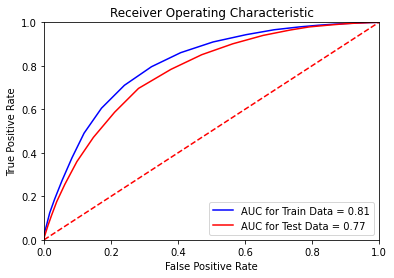

the maximum value of tpr*(1-fpr) 0.49988214447173457 for threshold 0.831
*************************************************************************************


Text(0.5, 6.0, 'Predicted label')

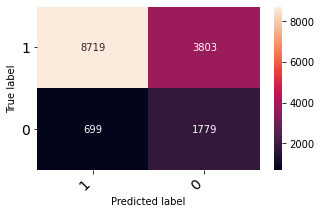

In [ ]:
count_vect = CountVectorizer(ngram_range=(1,2))

Xtrain_bigrams = count_vect.fit_transform(final_50ktrain['CleanedText'].values)
scaler = StandardScaler(with_mean = False)
scaler.fit_transform(Xtrain_bigrams)

Xtest_bigrams = count_vect.transform(final_50ktest['CleanedText'].values)
scaler.transform(Xtest_bigrams)

knn = KNeighborsClassifier(n_neighbors = 59 , algorithm = 'brute')

knn.fit(Xtrain_bigrams, final_50ktrain['Score'])
predOnTest = knn.predict_proba(Xtest_bigrams)
predOnTrain = knn.predict_proba(Xtrain_bigrams)

Trainfpr,Traintpr,Trthrsh = roc_curve(final_50ktrain['Score'], predOnTrain[:,1])
train_auc = auc(Trainfpr,Traintpr)

Testfpr,Testtpr,Tsthrsh = roc_curve(final_50ktest['Score'], predOnTest[:,1])
test_auc = auc(Testfpr,Testtpr)

print("*************************************************************************************")
print("Performance on test data and train is", test_auc ,"&", train_auc,"resp.")
print("*************************************************************************************")

## Ploting ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(Trainfpr, Traintpr, 'b', label = 'AUC for Train Data = %0.2f' % train_auc)
plt.plot(Testfpr, Testtpr, 'r', label = 'AUC for Test Data = %0.2f' % test_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

best_t = find_best_threshold(Tsthrsh, Testfpr, Testtpr)

print("*************************************************************************************")

class_names = [1,0]
confMat=confusion_matrix(final_50ktest['Score'], predict_with_best_t(predOnTest[:,1], best_t), labels = class_names)
df_cm = pd.DataFrame(confMat, index=class_names, columns=class_names)
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# kNN for Tf-Idf encoding

**using kd-tree algorithm , hyperparameter tuning - ploting k v/s AUROC for Validation dataset and Train dataset **

100%|██████████| 29/29 [5:55:00<00:00, 716.56s/it]


Text(0, 0.5, 'AUROC score')

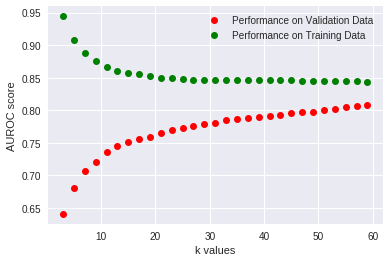

In [ ]:
myList = list(range(3,61,2));

tcvs = TimeSeriesSplit(n_splits = 10, max_train_size = round(final_20ktrain.shape[0]*0.9))
ValMeanScore=[]; TrainMeanScore=[];
Tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df = 10, max_features = 500)

for k in tqdm(myList) :
    
    ValScore=[];TrainScore=[];
    knn = KNeighborsClassifier(n_neighbors=k ,algorithm = "kd_tree")
    
    for train ,val in tcvs.split(final_20ktrain) :
        
        Xtrain_bigrams = Tf_idf_vect.fit_transform(final_20ktrain.iloc[train]['CleanedText'].values)
        scaler = StandardScaler(with_mean = False)
        scaler.fit_transform(Xtrain_bigrams)
        
        Xval_bigrams = Tf_idf_vect.transform(final_20ktrain.iloc[val]['CleanedText'].values)
        scaler.transform(Xval_bigrams)
                
        Ytrain_labels = final_20ktrain.iloc[train]['Score']
        Yval_labels = final_20ktrain.iloc[val]['Score']
        
        knn.fit(Xtrain_bigrams.toarray(), Ytrain_labels)
        
        predOnVal = knn.predict_proba(Xval_bigrams.toarray())
        predOnTrain = knn.predict_proba(Xtrain_bigrams.toarray())
        
        fpr,tpr,_ = roc_curve(Yval_labels, predOnVal[:,1])
        AUCOnVal = auc(fpr,tpr)
        fpr,tpr,_ = roc_curve(Ytrain_labels, predOnTrain[:,1])
        AUCOnTrain = auc(fpr,tpr)
        
        ValScore.append(AUCOnVal)
        TrainScore.append(AUCOnTrain)
        
    ValMeanScore.append((k,sum(ValScore)/len(ValScore)))
    TrainMeanScore.append((k,sum(TrainScore)/len(TrainScore)))
    
#just to free up some memory space :
Xval_bigrams =[];train=[];val=[];

ValMeanScore = dict(ValMeanScore)
TrainMeanScore = dict(TrainMeanScore)

#Bestk = list(ValMeanScore.keys())[list(ValMeanScore.values()).index(max(ValMeanScore.values()))]

plt.plot(ValMeanScore.keys(), ValMeanScore.values(), "ro", label = "Performance on Validation Data")
plt.plot(TrainMeanScore.keys(), TrainMeanScore.values(),"go", label = "Performance on Training Data")
plt.legend()
plt.xlabel("k values")
plt.ylabel("AUROC score")


**Performance on Test Data with optimal k value , ROC Curves and Confusion Matrix**

*************************************************************************************
Performance on test and train data is 0.8115025334809114 & 0.8457668603825937 resp.
*************************************************************************************


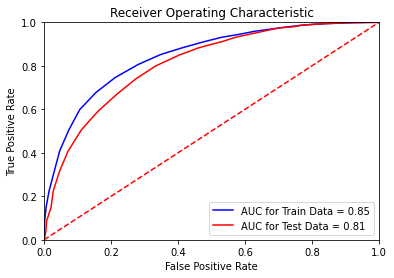

the maximum value of tpr*(1-fpr) 0.537274667604546 for threshold 0.831
*************************************************************************************


Text(0.5, 6.0, 'Predicted label')

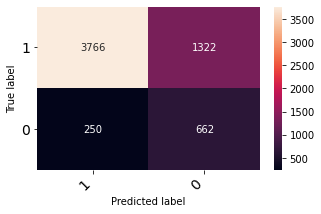

In [ ]:
Tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df = 10, max_features = 500)

Xtrain_bigrams = Tf_idf_vect.fit_transform(final_20ktrain['CleanedText'].values)
scaler = StandardScaler(with_mean = False)
scaler.fit_transform(Xtrain_bigrams)

Xtest_bigrams = Tf_idf_vect.transform(final_20ktest['CleanedText'].values)
scaler.transform(Xtest_bigrams)

knn = KNeighborsClassifier(n_neighbors =  59 , algorithm = 'kd_tree')

knn.fit(Xtrain_bigrams.toarray(), final_20ktrain['Score'])
predOnTest = knn.predict_proba(Xtest_bigrams.toarray())
predOnTrain = knn.predict_proba(Xtrain_bigrams.toarray())

Trainfpr,Traintpr,Trthrsh = roc_curve(final_20ktrain['Score'], predOnTrain[:,1])
train_auc = auc(Trainfpr,Traintpr)

Testfpr,Testtpr,Tsthrsh = roc_curve(final_20ktest['Score'], predOnTest[:,1])
test_auc = auc(Testfpr,Testtpr)

print("*************************************************************************************")
print("Performance on test and train data is", test_auc,"&",train_auc,"resp.")
print("*************************************************************************************")

## Ploting ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(Trainfpr, Traintpr, 'b', label = 'AUC for Train Data = %0.2f' % train_auc)
plt.plot(Testfpr, Testtpr, 'r', label = 'AUC for Test Data = %0.2f' % test_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

best_t = find_best_threshold(Tsthrsh, Testfpr, Testtpr)

print("*************************************************************************************")
Xtrain_bigrams = [];

class_names = [1,0]
confMat=confusion_matrix(final_20ktest['Score'], predict_with_best_t(predOnTest[:,1], best_t),labels = class_names)
df_cm = pd.DataFrame(confMat, index=class_names, columns=class_names)
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

**using Brute Force algorithm , hyperparameter tuning - ploting k v/s AUROC for Validation dataset and Train dataset **

100%|██████████| 29/29 [2:02:24<00:00, 254.35s/it]


Text(0, 0.5, 'AUROC score')

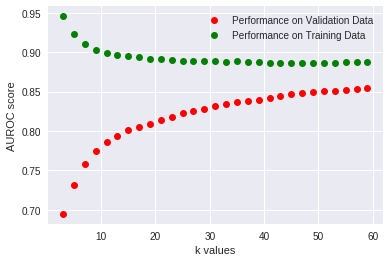

In [ ]:
myList = list(range(3,61,2));

tcvs = TimeSeriesSplit(n_splits = 10, max_train_size = round(final_50ktrain.shape[0]*0.9))
ValMeanScore=[]; TrainMeanScore=[];

tcvs = TimeSeriesSplit(n_splits = 10, max_train_size = round(final_50ktrain.shape[0]*0.9))
TrainMeanScore=[];ValMeanScore=[];

Tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))

for k in tqdm(myList) :
  
    ValScore=[]; TrainScore=[];
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = "brute")
    
    for train , val in tcvs.split(final_50ktrain) :
        
        Xtrain_bigrams = Tf_idf_vect.fit_transform(final_50ktrain.iloc[train]['CleanedText'].values)
        scaler = StandardScaler(with_mean=False) 
        scaler.fit_transform(Xtrain_bigrams)
        
        Xval_bigrams = Tf_idf_vect.transform(final_50ktrain.iloc[val]['CleanedText'].values)
        scaler.transform(Xval_bigrams)

        knn.fit(Xtrain_bigrams, final_50ktrain.iloc[train]['Score'])
        predOnVal = knn.predict_proba(Xval_bigrams)
        predOnTrain = knn.predict_proba(Xtrain_bigrams)
        
        fpr,tpr,_ = roc_curve(final_50ktrain.iloc[val]['Score'], predOnVal[:,1])
        AUCOnVal = auc(fpr,tpr)
        fpr,tpr,_ = roc_curve(final_50ktrain.iloc[train]['Score'], predOnTrain[:,1])
        AUCOnTrain = auc(fpr,tpr)
        
        ValScore.append(AUCOnVal)
        TrainScore.append(AUCOnTrain)
    
    TrainMeanScore.append((k,sum(TrainScore)/len(TrainScore)))
    ValMeanScore.append((k,sum(ValScore)/len(ValScore)))

#just to free up some memory space :
Xval_bigrams =[];train=[];val=[];

TrainMeanScore = dict(TrainMeanScore)
ValMeanScore = dict(ValMeanScore)

plt.plot(ValMeanScore.keys(), ValMeanScore.values(), "ro", label = "Performance on Validation Data")
plt.plot(TrainMeanScore.keys(), TrainMeanScore.values(),"go", label = "Performance on Training Data")
plt.legend()
plt.xlabel("k values")
plt.ylabel("AUROC score")


**Performance on Test Data with optimal k value , ROC Curves and Confusion Matrix**

*************************************************************************************
Performance on test data and train is 0.8670559830839772 & 0.8933045623456473 resp.
*************************************************************************************


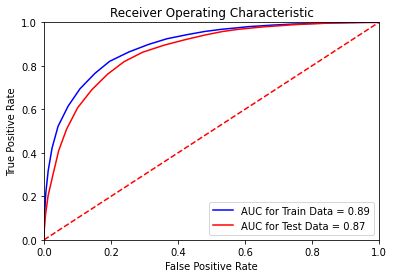

the maximum value of tpr*(1-fpr) 0.6235506219304227 for threshold 0.831
*************************************************************************************


In [ ]:
Xval_bigrams =[];train=[];val=[];

Tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
Xtrain_bigrams = Tf_idf_vect.fit_transform(final_50ktrain['CleanedText'].values)
scaler = StandardScaler(with_mean = False)
scaler.fit_transform(Xtrain_bigrams)

Xtest_bigrams = Tf_idf_vect.transform(final_50ktest['CleanedText'].values)
scaler.transform(Xtest_bigrams)

knn = KNeighborsClassifier(n_neighbors = 59 , algorithm = 'brute')

knn.fit(Xtrain_bigrams, final_50ktrain['Score'])
predOnTest = knn.predict_proba(Xtest_bigrams)
predOnTrain = knn.predict_proba(Xtrain_bigrams)

Trainfpr, Traintpr, Trthrsh  = roc_curve(final_50ktrain['Score'], predOnTrain[:,1])
train_auc = auc(Trainfpr,Traintpr)

Testfpr, Testtpr, Tsthrsh = roc_curve(final_50ktest['Score'], predOnTest[:,1])
test_auc = auc(Testfpr,Testtpr)


print("*************************************************************************************")
print("Performance on test data and train is", test_auc ,"&", train_auc,"resp.")
print("*************************************************************************************")

## Ploting ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(Trainfpr, Traintpr, 'b', label = 'AUC for Train Data = %0.2f' % train_auc)
plt.plot(Testfpr, Testtpr, 'r', label = 'AUC for Test Data = %0.2f' % test_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

best_t = find_best_threshold(Tsthrsh, Testfpr, Testtpr)
print("*************************************************************************************")

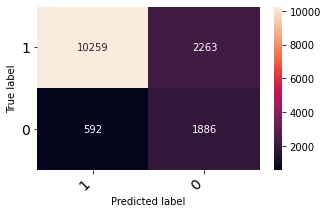

In [ ]:
class_names = [1,0]
confMat=confusion_matrix(final_50ktest['Score'], predict_with_best_t(predOnTest[:,1], best_t),labels = class_names)
df_cm = pd.DataFrame(confMat, index=class_names, columns=class_names)
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#kNN for Avg. W2V
**Function for training a W2V model**

In [ ]:
#@title
def W2V_Vectorizer(DataCorpus, min_count = 5, size = 50):
    
    list_of_sent=[]
    for sent in DataCorpus:
        list_of_sent.append(sent.split())

    w2v_model=Word2Vec(list_of_sent,min_count = min_count, size = size, workers=4)
    w2v_words = list(w2v_model.wv.vocab)
    
    sent_vectors = []; i=0;
    for sent in list_of_sent:
        sent_vec = np.zeros(size) 
        cnt_words =0; 
        for word in sent: 
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
        
    return pd.DataFrame(sent_vectors)

**using kd-tree algorithm , hyperparameter tuning - ploting k v/s AUROC for Validation dataset and Train dataset **

100%|██████████| 29/29 [5:29:51<00:00, 688.96s/it]


Text(0, 0.5, 'AUROC score')

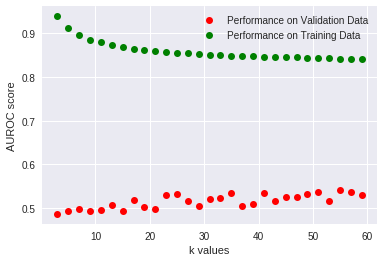

In [ ]:
myList = list(range(3,61,2));

tcvs = TimeSeriesSplit(n_splits = 10, max_train_size = round(final_50ktrain.shape[0]*0.9))
ValMeanScore=[]; TrainMeanScore=[];

for k in tqdm(myList) :
    
    ValScore=[];TrainScore=[];
    knn = KNeighborsClassifier(n_neighbors=k ,algorithm = "kd_tree")
    
    for train ,val in tcvs.split(final_50ktrain) :
         
        TrainW2V = W2V_Vectorizer(final_50ktrain.iloc[train]['CleanedText'].values, size = 50)
        scaler = StandardScaler(with_mean = False)
        scaler.fit_transform(TrainW2V)
        
        ValW2V = W2V_Vectorizer(final_50ktrain.iloc[val]['CleanedText'].values, size = 50)
        scaler.transform(ValW2V)
                
        Ytrain_labels = final_50ktrain.iloc[train]['Score']
        Yval_labels = final_50ktrain.iloc[val]['Score']
        
        knn.fit(TrainW2V, Ytrain_labels)
        
        predOnVal = knn.predict_proba(ValW2V)
        predOnTrain = knn.predict_proba(TrainW2V)
        
        fpr,tpr,_ = roc_curve(Yval_labels, predOnVal[:,1])
        AUCOnVal = auc(fpr,tpr)
        fpr,tpr,_ = roc_curve(Ytrain_labels, predOnTrain[:,1])
        AUCOnTrain = auc(fpr,tpr)
        
        ValScore.append(AUCOnVal)
        TrainScore.append(AUCOnTrain)
        
    ValMeanScore.append((k,sum(ValScore)/len(ValScore)))
    TrainMeanScore.append((k,sum(TrainScore)/len(TrainScore)))
    
ValMeanScore = dict(ValMeanScore)
TrainMeanScore = dict(TrainMeanScore)

plt.plot(ValMeanScore.keys(), ValMeanScore.values(), "ro", label = "Performance on Validation Data")
plt.plot(TrainMeanScore.keys(), TrainMeanScore.values(), "go", label = "Performance on Training Data")
plt.legend()
plt.xlabel("k values")
plt.ylabel("AUROC score")


**Performance on Test Data with optimal k value , ROC Curves and Confusion Matrix**

In [ ]:
TrainW2V = W2V_Vectorizer(final_50ktrain['CleanedText'].values, size = 50)
scaler = StandardScaler(with_mean = False)
scaler.fit_transform(TrainW2V)

TestW2V = W2V_Vectorizer(final_50ktest['CleanedText'].values, size = 50)
scaler.transform(TestW2V)

knn = KNeighborsClassifier(n_neighbors = 59 , algorithm = 'kd_tree')

knn.fit(TrainW2V, final_50ktrain['Score'])
predOnTest = knn.predict_proba(TestW2V)
predOnTrain = knn.predict_proba(TrainW2V)

Trainfpr, Traintpr, Trthrsh = roc_curve(final_50ktrain['Score'], predOnTrain[:,1])
train_auc = auc(Trainfpr,Traintpr)

Testfpr, Testtpr, Tsthrsh = roc_curve(final_50ktest['Score'], predOnTest[:,1])
test_auc = auc(Testfpr,Testtpr)


print("*************************************************************************************")
print("Performance on test data and train is", test_auc ,"&", train_auc,"resp.")
print("*************************************************************************************")

## Ploting ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(Trainfpr, Traintpr, 'b', label = 'AUC for Train Data = %0.2f' % train_auc)
plt.plot(Testfpr, Testtpr, 'r', label = 'AUC for Test Data = %0.2f' % test_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

best_t = find_best_threshold(Tsthrsh, Testfpr, Testtpr)

print("*************************************************************************************")

class_names = [1,0]
confMat=confusion_matrix(final_50ktest['Score'], predict_with_best_t(predOnTest[:,1], best_t),labels = class_names)
df_cm = pd.DataFrame(confMat, index=class_names, columns=class_names)
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


**using brute force, hyperparameter tuning - ploting k v/s AUROC for Validation dataset and Train dataset **

100%|██████████| 29/29 [2:50:35<00:00, 349.43s/it]


Text(0, 0.5, 'AUROC score')

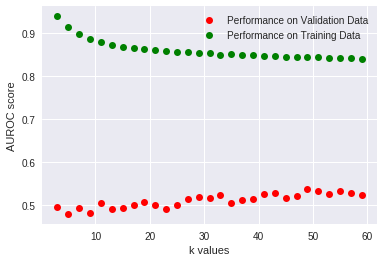

In [ ]:
myList = list(range(3,61,2));

tcvs = TimeSeriesSplit(n_splits = 10, max_train_size = round(final_50ktrain.shape[0]*0.9))
ValMeanScore=[]; TrainMeanScore=[];

for k in tqdm(myList) :
    
    ValScore=[];TrainScore=[];
    knn = KNeighborsClassifier(n_neighbors=k ,algorithm = "brute")
    
    for train ,val in tcvs.split(final_50ktrain) :
         
        TrainW2V = W2V_Vectorizer(final_50ktrain.iloc[train]['CleanedText'].values, size = 50)
        scaler = StandardScaler(with_mean = False)
        scaler.fit_transform(TrainW2V)
        
        ValW2V = W2V_Vectorizer(final_50ktrain.iloc[val]['CleanedText'].values, size = 50)
        scaler.transform(ValW2V)
                
        Ytrain_labels = final_50ktrain.iloc[train]['Score']
        Yval_labels = final_50ktrain.iloc[val]['Score']
        
        knn.fit(TrainW2V, Ytrain_labels)
        
        predOnVal = knn.predict_proba(ValW2V)
        predOnTrain = knn.predict_proba(TrainW2V)
        
        fpr,tpr,_ = roc_curve(Yval_labels, predOnVal[:,1])
        AUCOnVal = auc(fpr,tpr)
        fpr,tpr,_ = roc_curve(Ytrain_labels, predOnTrain[:,1])
        AUCOnTrain = auc(fpr,tpr)
        
        ValScore.append(AUCOnVal)
        TrainScore.append(AUCOnTrain)
        
    ValMeanScore.append((k,sum(ValScore)/len(ValScore)))
    TrainMeanScore.append((k,sum(TrainScore)/len(TrainScore)))
    
ValMeanScore = dict(ValMeanScore)
TrainMeanScore = dict(TrainMeanScore)

plt.plot(ValMeanScore.keys(), ValMeanScore.values(), "ro", label = "Performance on Validation Data")
plt.plot(TrainMeanScore.keys(), TrainMeanScore.values(), "go", label = "Performance on Training Data")
plt.legend()
plt.xlabel("k values")
plt.ylabel("AUROC score")


**Performance on Test Data with optimal k value , ROC Curves and Confusion Matrix**

*************************************************************************************
Performance on test data and train is 0.7816130938039768 & 0.8970330349615094 resp.
*************************************************************************************


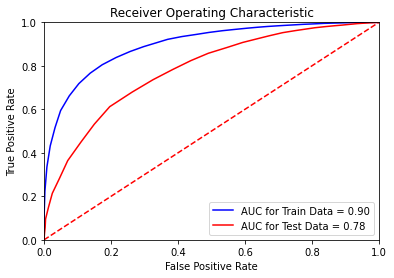

the maximum value of tpr*(1-fpr) 0.5006130936750672 for threshold 0.776
*************************************************************************************


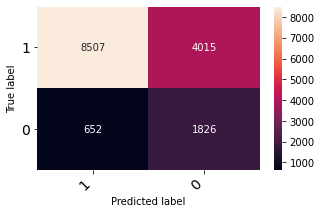

In [ ]:
TrainW2V = W2V_Vectorizer(final_50ktrain['CleanedText'].values, size = 50)
scaler = StandardScaler(with_mean = False)
scaler.fit_transform(TrainW2V)

TestW2V = W2V_Vectorizer(final_50ktest['CleanedText'].values, size = 50)
scaler.transform(TestW2V)

knn = KNeighborsClassifier(n_neighbors = 49 , algorithm = 'brute')

knn.fit(TrainW2V, final_50ktrain['Score'])
predOnTest = knn.predict_proba(TestW2V)
predOnTrain = knn.predict_proba(TrainW2V)

Trainfpr,Traintpr,Trthrsh = roc_curve(final_50ktrain['Score'], predOnTrain[:,1])
train_auc = auc(Trainfpr,Traintpr)

Testfpr,Testtpr,Tsthrsh = roc_curve(final_50ktest['Score'], predOnTest[:,1])
test_auc = auc(Testfpr,Testtpr)


print("*************************************************************************************")
print("Performance on test data and train is", test_auc ,"&", train_auc,"resp.")
print("*************************************************************************************")

## Ploting ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(Trainfpr, Traintpr, 'b', label = 'AUC for Train Data = %0.2f' % train_auc)
plt.plot(Testfpr, Testtpr, 'r', label = 'AUC for Test Data = %0.2f' % test_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

best_t = find_best_threshold(Tsthrsh, Testfpr, Testtpr)

print("*************************************************************************************")

class_names = [1,0]
confMat=confusion_matrix(final_50ktest['Score'], predict_with_best_t(predOnTest[:,1], best_t),labels = class_names)
df_cm = pd.DataFrame(confMat, index=class_names, columns=class_names)
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


#kNN for Tf-idf weighted W2V
**Function to Train a Tf-idf weighted W2V model**

In [ ]:
#@title
def W2V_Tfidf_Vectorizer(DataCorpus, min_count = 5, size = 50 ):
  
  list_of_sent=[]
  for sent in DataCorpus:
      list_of_sent.append(sent.split())
  
  w2v_model=Word2Vec(list_of_sent, min_count = min_count, size = size, workers = 4)
  w2v_words = list(w2v_model.wv.vocab)
  
  model = TfidfVectorizer()
  tf_idf_matrix = model.fit_transform(DataCorpus)
  
  dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
  
  tfidf_sent_vectors = [];

  for sent in list_of_sent:
      sent_vec = np.zeros(50)
      weight_sum = 0; 
      for word in sent:
          if word in w2v_words:
              vec = w2v_model.wv[word]
              tf_idf = dictionary[word]*(sent.count(word)/len(sent))
              sent_vec += (vec * tf_idf)
              weight_sum += tf_idf
      if weight_sum != 0:
          sent_vec /= weight_sum
      tfidf_sent_vectors.append(sent_vec)

  return(pd.DataFrame(tfidf_sent_vectors))


**using kd tree based algorithm, hyperparameter tuning - ploting k v/s AUROC for Validation dataset and Train dataset **

100%|██████████| 29/29 [5:54:40<00:00, 752.07s/it]


Text(0, 0.5, 'AUROC score')

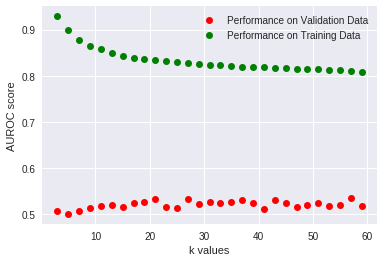

In [ ]:
myList = list(range(3,61,2));

tcvs = TimeSeriesSplit(n_splits = 10, max_train_size = round(final_50ktrain.shape[0]*0.9))
ValMeanScore=[]; TrainMeanScore=[];

for k in tqdm(myList) :
    
    ValScore=[];TrainScore=[];
    knn = KNeighborsClassifier(n_neighbors=k ,algorithm = "kd_tree")
    
    for train ,val in tcvs.split(final_50ktrain) :
         
        TrainW2V = W2V_Tfidf_Vectorizer(final_50ktrain.iloc[train]['CleanedText'].values, size = 50)
        scaler = StandardScaler(with_mean = False)
        scaler.fit_transform(TrainW2V)
        
        ValW2V = W2V_Tfidf_Vectorizer(final_50ktrain.iloc[val]['CleanedText'].values, size = 50)
        scaler.transform(ValW2V)
                
        Ytrain_labels = final_50ktrain.iloc[train]['Score']
        Yval_labels = final_50ktrain.iloc[val]['Score']
        
        knn.fit(TrainW2V, Ytrain_labels)
        
        predOnVal = knn.predict_proba(ValW2V)
        predOnTrain = knn.predict_proba(TrainW2V)
        
        fpr,tpr,_ = roc_curve(Yval_labels, predOnVal[:,1])
        AUCOnVal = auc(fpr,tpr)
        fpr,tpr,_ = roc_curve(Ytrain_labels, predOnTrain[:,1])
        AUCOnTrain = auc(fpr,tpr)
        
        ValScore.append(AUCOnVal)
        TrainScore.append(AUCOnTrain)
        
    ValMeanScore.append((k,sum(ValScore)/len(ValScore)))
    TrainMeanScore.append((k,sum(TrainScore)/len(TrainScore)))
    
ValMeanScore = dict(ValMeanScore)
TrainMeanScore = dict(TrainMeanScore)

plt.plot(ValMeanScore.keys(), ValMeanScore.values(), "ro", label = "Performance on Validation Data")
plt.plot(TrainMeanScore.keys(), TrainMeanScore.values(), "go", label = "Performance on Training Data")
plt.legend()
plt.xlabel("k values")
plt.ylabel("AUROC score")


**Performance on Test Data with optimal k value , ROC Curves and Confusion Matrix**

*************************************************************************************
Performance on test data and train is 0.7656991330448081 & 0.8661749819580365 resp.
*************************************************************************************


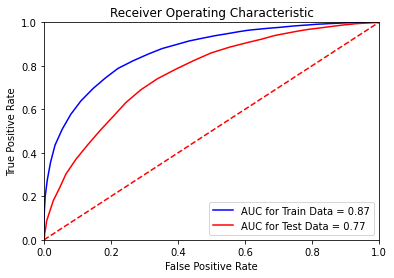

the maximum value of tpr*(1-fpr) 0.49051113140146946 for threshold 0.737
*************************************************************************************


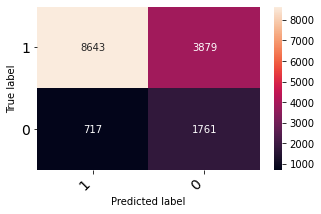

In [ ]:
TrainW2V = W2V_Tfidf_Vectorizer(final_50ktrain['CleanedText'].values, size = 50)
scaler = StandardScaler(with_mean = False)
scaler.fit_transform(TrainW2V)

TestW2V = W2V_Tfidf_Vectorizer(final_50ktest['CleanedText'].values, size = 50)
scaler.transform(TestW2V)

knn = KNeighborsClassifier(n_neighbors = 57 , algorithm = 'kd_tree')

knn.fit(TrainW2V, final_50ktrain['Score'])
predOnTest = knn.predict_proba(TestW2V)
predOnTrain = knn.predict_proba(TrainW2V)

Trainfpr,Traintpr,Trthrsh = roc_curve(final_50ktrain['Score'], predOnTrain[:,1])
train_auc = auc(Trainfpr,Traintpr)

Testfpr,Testtpr,Tsthrsh = roc_curve(final_50ktest['Score'], predOnTest[:,1])
test_auc = auc(Testfpr,Testtpr)


print("*************************************************************************************")
print("Performance on test data and train is", test_auc ,"&", train_auc,"resp.")
print("*************************************************************************************")

## Ploting ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(Trainfpr, Traintpr, 'b', label = 'AUC for Train Data = %0.2f' % train_auc)
plt.plot(Testfpr, Testtpr, 'r', label = 'AUC for Test Data = %0.2f' % test_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

best_t = find_best_threshold(Tsthrsh, Testfpr, Testtpr)

print("*************************************************************************************")

class_names = [1,0]
confMat=confusion_matrix(final_50ktest['Score'], predict_with_best_t(predOnTest[:,1], best_t), labels = class_names)
df_cm = pd.DataFrame(confMat, index=class_names, columns=class_names)
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


**using brute force, hyperparameter tuning - ploting k v/s AUROC for Validation dataset and Train dataset **

100%|██████████| 29/29 [3:32:51<00:00, 453.73s/it]


Text(0, 0.5, 'AUROC score')

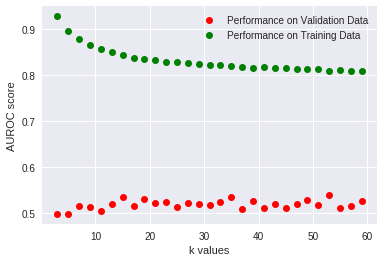

In [ ]:
myList = list(range(3,61,2));

tcvs = TimeSeriesSplit(n_splits = 10, max_train_size = round(final_50ktrain.shape[0]*0.9))
ValMeanScore=[]; TrainMeanScore=[];

for k in tqdm(myList) :
    
    ValScore=[];TrainScore=[];
    knn = KNeighborsClassifier(n_neighbors=k ,algorithm = "brute")
    
    for train ,val in tcvs.split(final_50ktrain) :
         
        TrainW2V = W2V_Tfidf_Vectorizer(final_50ktrain.iloc[train]['CleanedText'].values, size = 50)
        scaler = StandardScaler(with_mean = False)
        scaler.fit_transform(TrainW2V)
        
        ValW2V = W2V_Tfidf_Vectorizer(final_50ktrain.iloc[val]['CleanedText'].values, size = 50)
        scaler.transform(ValW2V)
                
        Ytrain_labels = final_50ktrain.iloc[train]['Score']
        Yval_labels = final_50ktrain.iloc[val]['Score']
        
        knn.fit(TrainW2V, Ytrain_labels)
        
        predOnVal = knn.predict_proba(ValW2V)
        predOnTrain = knn.predict_proba(TrainW2V)
        
        fpr,tpr,_ = roc_curve(Yval_labels, predOnVal[:,1])
        AUCOnVal = auc(fpr,tpr)
        fpr,tpr,_ = roc_curve(Ytrain_labels, predOnTrain[:,1])
        AUCOnTrain = auc(fpr,tpr)
        
        ValScore.append(AUCOnVal)
        TrainScore.append(AUCOnTrain)
        
    ValMeanScore.append((k,sum(ValScore)/len(ValScore)))
    TrainMeanScore.append((k,sum(TrainScore)/len(TrainScore)))
    
ValMeanScore = dict(ValMeanScore)
TrainMeanScore = dict(TrainMeanScore)

plt.plot(ValMeanScore.keys(), ValMeanScore.values(), "ro", label = "Performance on Validation Data")
plt.plot(TrainMeanScore.keys(), TrainMeanScore.values(), "go", label = "Performance on Training Data")
plt.legend()
plt.xlabel("k values")
plt.ylabel("AUROC score")


**Performance on Test Data with optimal k value , ROC Curves and Confusion Matrix**

*************************************************************************************
Performance on test data and train is 0.755817380458013 & 0.8664101651800149 resp.
*************************************************************************************


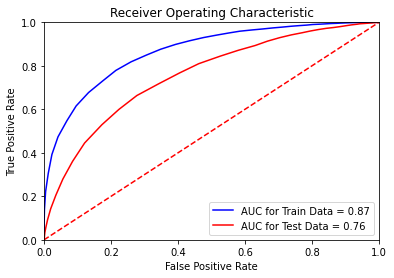

the maximum value of tpr*(1-fpr) 0.47964686268390394 for threshold 0.755
*************************************************************************************


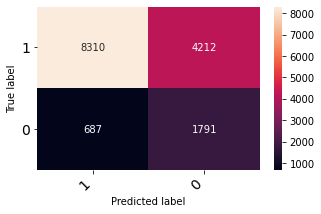

In [ ]:
TrainW2V = W2V_Tfidf_Vectorizer(final_50ktrain['CleanedText'].values, size = 50)
scaler = StandardScaler(with_mean = False)
scaler.fit_transform(TrainW2V)

TestW2V = W2V_Tfidf_Vectorizer(final_50ktest['CleanedText'].values, size = 50)
scaler.transform(TestW2V)

knn = KNeighborsClassifier(n_neighbors = 53 , algorithm = 'brute')

knn.fit(TrainW2V, final_50ktrain['Score'])
predOnTest = knn.predict_proba(TestW2V)
predOnTrain = knn.predict_proba(TrainW2V)

Trainfpr,Traintpr,Trthrsh = roc_curve(final_50ktrain['Score'], predOnTrain[:,1])
train_auc = auc(Trainfpr,Traintpr)

Testfpr,Testtpr,Tsthrsh = roc_curve(final_50ktest['Score'], predOnTest[:,1])
test_auc = auc(Testfpr,Testtpr)


print("*************************************************************************************")
print("Performance on test data and train is", test_auc ,"&", train_auc,"resp.")
print("*************************************************************************************")

## Ploting ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(Trainfpr, Traintpr, 'b', label = 'AUC for Train Data = %0.2f' % train_auc)
plt.plot(Testfpr, Testtpr, 'r', label = 'AUC for Test Data = %0.2f' % test_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

best_t = find_best_threshold(Tsthrsh, Testfpr, Testtpr)

print("*************************************************************************************")

class_names = [1,0]
confMat=confusion_matrix(final_50ktest['Score'], predict_with_best_t(predOnTest[:,1], best_t), labels = class_names)
df_cm = pd.DataFrame(confMat, index=class_names, columns=class_names)
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


#Final Results kNN for all different encoding schemes using  both "kd tree" & "brute force" .

In [ ]:
x = PrettyTable(["Vectorizer","Variant","AUROC","Optimal k-values","Time taken"])

x.add_row(["BoW","kd-tree(20k)","0.808","107","698.79s/it"])
x.add_row(["BoW","brute force(50k)","0.813","89","292.21s/it"])
x.add_row(["Tf-idf","kd-tree(20k)","0.820","95","712.96s/it"])
x.add_row(["Tf-idf","brute force(50k)","0.886","117","288.98s/it"])
x.add_row(["Avg. W2V","kd-tree(50k)","0.816","81","848.45s/it"])
x.add_row(["Avg. W2V","brute force(50k)","0.810","99","388.97s/it"])
x.add_row(["Tf-idf Weighted W2V","kd-tree(50k)","0.783","105","809.43s/it"])
x.add_row(["Tf-idf Weighted W2V","brute force(50k)","0.783","123","433.20s/it"])

x.align["Variant"] = "l"
x.align["Vectorizer"] = "l"

y = PrettyTable(["Vectorizer","Variant","AUROC","Optimal k-values","Time taken"])

y.add_row(["BoW","kd-tree(20k)","0.79","59","647.74s/it"])
y.add_row(["BoW","brute force(50k)","0.76","59","247.92s/it"])
y.add_row(["Tf-idf","kd-tree(20k)","0.81","59","716.56s/it"])
y.add_row(["Tf-idf","brute force(50k)","0.86","59","254.35s/it"])
y.add_row(["Avg. W2V","kd-tree(50k)","0.77","59","688.96s/it"])
y.add_row(["Avg. W2V","brute force(50k)","0.72","49","349.43s/it"])
y.add_row(["Tf-idf Weighted W2V","kd-tree(50k)","0.74","57","752.07s/it"])
y.add_row(["Tf-idf Weighted W2V","brute force(50k)","0.74","53","453.73s/it"])

y.align["Variant"] = "l"
y.align["Vectorizer"] = "l"

print("*************************************************************************************************")
print("Results Summary for k in range of 31-120 in steps of 4")
print(x)

print("*************************************************************************************************")
print("Results Summary for k in range of 3-60 in steps of 2")
print(y)

*************************************************************************************************
Results Summary for k in range of 31-120 in steps of 4
+---------------------+------------------+-------+------------------+------------+
| Vectorizer          | Variant          | AUROC | Optimal k-values | Time taken |
+---------------------+------------------+-------+------------------+------------+
| BoW                 | kd-tree(20k)     | 0.808 |       107        | 698.79s/it |
| BoW                 | brute force(50k) | 0.813 |        89        | 292.21s/it |
| Tf-idf              | kd-tree(20k)     | 0.820 |        95        | 712.96s/it |
| Tf-idf              | brute force(50k) | 0.886 |       117        | 288.98s/it |
| Avg. W2V            | kd-tree(50k)     | 0.816 |        81        | 848.45s/it |
| Avg. W2V            | brute force(50k) | 0.810 |        99        | 388.97s/it |
| Tf-idf Weighted W2V | kd-tree(50k)     | 0.783 |       105        | 809.43s/it |
| Tf-idf Weighted